In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/travclan/travclan_dataset.csv


**Analysis**

In [12]:
# ================================================================
# HOTEL BOOKING DATA ANALYSIS
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 1. DATASET LOADING AND OVERVIEW
print("\n1. DATASET OVERVIEW")
print("-" * 50)

df = pd.read_csv('/kaggle/input/travclan/travclan_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Number of records: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")

# 2. DATA PREPARATION AND EXPLORATION
print("\n2. DATA PREPARATION AND EXPLORATION")
print("-" * 50)

date_columns = ['booking_date', 'check_in_date', 'check_out_date', 'travel_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Creating additional metrics
df['profit_margin'] = ((df['selling_price'] - df['costprice']) / df['selling_price'] * 100)
df['total_discount'] = df['cashback'] + df['coupon_redeem']
df['stay_duration'] = (df['check_out_date'] - df['check_in_date']).dt.days

print("Missing values check:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# 3. QUESTION 1:

# 3.1
print("\n3.1 TRENDS AND PATTERNS")
print("-" * 50)

# Trend 1: Booking Status Distribution
booking_status_dist = df['booking_status'].value_counts()
cancellation_rate = (booking_status_dist.get('Cancelled', 0) / len(df) * 100)
print("TREND 1: Booking Status Distribution")
print(booking_status_dist)
print(f"Cancellation Rate: {cancellation_rate:.1f}%")

# Trend 2: Channel Performance
print("\nTREND 2: Channel Performance Analysis")
channel_analysis = df.groupby('booking_channel').agg({
    'selling_price': 'mean',
    'booking_status': lambda x: (x == 'Confirmed').sum() / len(x) * 100
}).round(2)
channel_analysis.columns = ['Avg_Selling_Price', 'Confirmation_Rate_%']
print(channel_analysis)

# Trend 3: Room Type and Pricing
print("\nTREND 3: Room Type and Pricing Patterns")
room_analysis = df.groupby('room_type').agg({
    'selling_price': 'mean',
    'profit_margin': 'mean',
    'num_rooms_booked': 'mean'
}).round(2)
print(room_analysis)

# 3.2
print("\n3.2 BOOKING PATTERNS ANALYSIS")
print("-" * 70)

# Channel patterns
channel_patterns = df.groupby(['booking_channel', 'channel_of_booking']).size().reset_index(name='count')
print("CHANNEL PATTERNS:")
print(channel_patterns)

# Room type patterns
room_patterns = df.groupby(['room_type', 'stay_type']).agg({
    'selling_price': 'mean',
    'star_rating': 'mean'
}).round(2)
print("\nROOM TYPE PATTERNS:")
print(room_patterns)

# Star rating patterns
star_patterns = df.groupby('star_rating').agg({
    'selling_price': 'mean',
    'booking_value': 'mean',
    'profit_margin': 'mean'
}).round(2)
print("\nSTAR RATING PATTERNS:")
print(star_patterns)

# 3.3
print("\n3.3 CANCELLATION BEHAVIOR ANALYSIS")
print("-" * 40)

cancellation_analysis = df.groupby('booking_status').agg({
    'refund_amount': 'mean',
    'total_discount': 'mean',
    'selling_price': 'mean'
}).round(2)
print("Cancellation vs Confirmation Metrics:")
print(cancellation_analysis)

# 4. QUESTION 2: 
print("\n" + "="*80)
print("4. QUESTION 2: ROOT CAUSE ANALYSIS")
print("="*80)

# 4.1
print("\n4.1 REASONS FOR CANCELLATION")
print("-" * 45)

cancelled_bookings = df[df['booking_status'] == 'Cancelled']
confirmed_bookings = df[df['booking_status'] == 'Confirmed']

print("CANCELLATION CHARACTERISTICS:")
if not cancelled_bookings.empty:
    print(f"Cancelled bookings analysis:")
    print(f"- Average selling price: ${cancelled_bookings['selling_price'].mean():,.2f}")
    print(f"- Most common room type: {cancelled_bookings['room_type'].mode().iloc[0]}")
    print(f"- Most common channel: {cancelled_bookings['booking_channel'].mode().iloc[0]}")
    print(f"- Average refund amount: ${cancelled_bookings['refund_amount'].mean():,.2f}")

# 4.2
print("\n4.2 CHANNEL AND PROPERTY TYPE PERFORMANCE")
print("-" * 45)

channel_performance = df.groupby('booking_channel').agg({
    'selling_price': ['mean', 'count'],
    'booking_status': lambda x: (x == 'Confirmed').mean() * 100
}).round(2)
print("CHANNEL PERFORMANCE:")
print(channel_performance)

# 4.3
print("\n4.3 TEMPORAL AND SEASONAL TRENDS")
print("-" * 35)

df['booking_month'] = df['booking_date'].dt.month
df['travel_month'] = df['travel_date'].dt.month
df['lead_time'] = (df['travel_date'] - df['booking_date']).dt.days
df['booking_day_of_week'] = df['booking_date'].dt.day_name()

# Monthly booking patterns
print("MONTHLY BOOKING PATTERNS")
monthly_stats = df.groupby('booking_month').agg({
    'booking_status': lambda x: (x == 'Confirmed').mean() * 100,
    'selling_price': 'mean',
    'customer_id': 'count'
}).round(2)
monthly_stats.columns = ['Confirmation_Rate_%', 'Avg_Price', 'Total_Bookings']
print(monthly_stats)

# Day of week patterns
print("\nDAY OF WEEK BOOKING PATTERNS")
dow_stats = df.groupby('booking_day_of_week').agg({
    'booking_status': lambda x: (x == 'Confirmed').mean() * 100,
    'selling_price': 'mean',
    'customer_id': 'count'
}).round(2)
dow_stats.columns = ['Confirmation_Rate_%', 'Avg_Price', 'Total_Bookings']
print(dow_stats)

# 5. QUESTION 3:
print("\n" + "="*80)
print("5. QUESTION 3: BUSINESS RECOMMENDATIONS")
print("="*80)

# 5.1
print("\n5.1 PROFITABILITY ANALYSIS")
print("-" * 50)

profit_analysis = df.groupby(['room_type', 'stay_type']).agg({
    'profit_margin': 'mean',
    'selling_price': 'mean',
    'total_discount': 'mean'
}).round(2)
print("PROFITABILITY BY SEGMENT:")
print(profit_analysis)

# 5.2
print("\n5.2 PRICING STRATEGY")
print("-" * 50)

channel_economics = df.groupby('booking_channel').agg({
    'selling_price': 'mean',
    'total_discount': 'mean',
    'profit_margin': 'mean'
}).round(2)
print("CHANNEL ECONOMICS:")
print(channel_economics)


1. DATASET OVERVIEW
--------------------------------------------------
Dataset Shape: (30000, 24)
Number of records: 30,000
Number of columns: 24

2. DATA PREPARATION AND EXPLORATION
--------------------------------------------------
Missing values check:
check_in_date     5468
check_out_date    5468
stay_duration     5468
dtype: int64

3.1 TRENDS AND PATTERNS
--------------------------------------------------
TREND 1: Booking Status Distribution
booking_status
Confirmed    21672
Cancelled     6070
Failed        2258
Name: count, dtype: int64
Cancellation Rate: 20.2%

TREND 2: Channel Performance Analysis
                 Avg_Selling_Price  Confirmation_Rate_%
booking_channel                                        
Mobile App                29422.51                67.54
Travel Agent              29371.01                66.19
Web                       29597.38                77.21

TREND 3: Room Type and Pricing Patterns
           selling_price  profit_margin  num_rooms_booked
room_ty

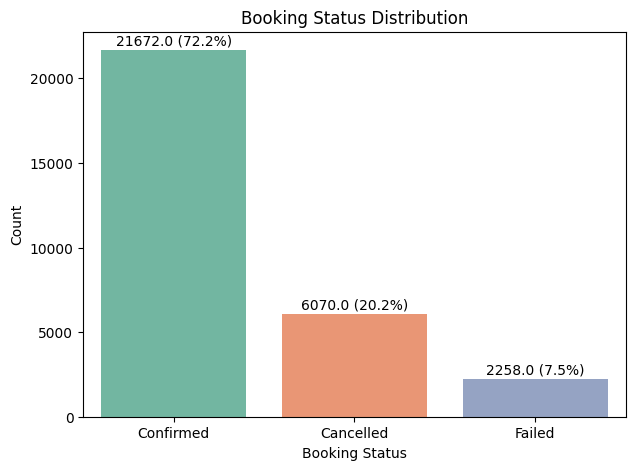

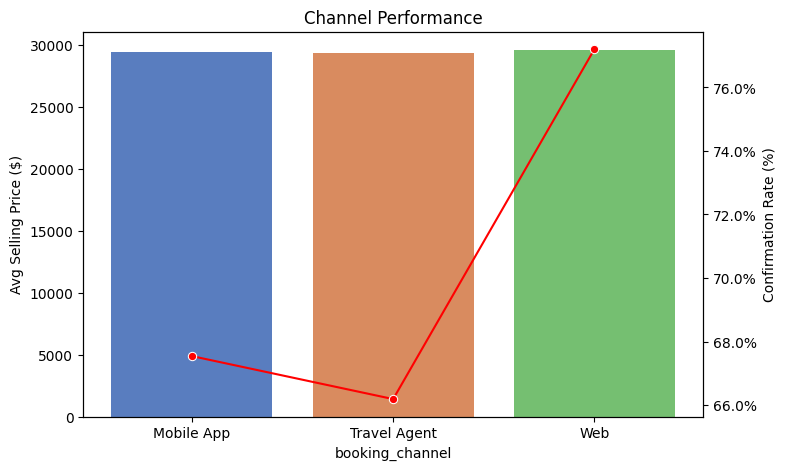

In [14]:
import matplotlib.ticker as mtick

# Booking Status Distribution
plt.figure(figsize=(7, 5))
sns.countplot(data=df, x='booking_status', palette='Set2')
plt.title('Booking Status Distribution')
plt.xlabel('Booking Status')
plt.ylabel('Count')
# Add text labels
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2., height + total*0.01, f'{height} ({height/total:.1%})', ha="center")
plt.show()

# Channel Performance
channel_summary = df.groupby('booking_channel').agg(
    Avg_Selling_Price=('selling_price', 'mean'),
    Confirmation_Rate=('booking_status', lambda x: (x == 'Confirmed').mean() * 100)
).reset_index()

fig, ax1 = plt.subplots(figsize=(8,5))
sns.barplot(x='booking_channel', y='Avg_Selling_Price', data=channel_summary, ax=ax1, palette='muted')
ax1.set_ylabel('Avg Selling Price ($)')
ax1.set_title('Channel Performance')

ax2 = ax1.twinx()
sns.lineplot(x='booking_channel', y='Confirmation_Rate', data=channel_summary, sort=False, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Confirmation Rate (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

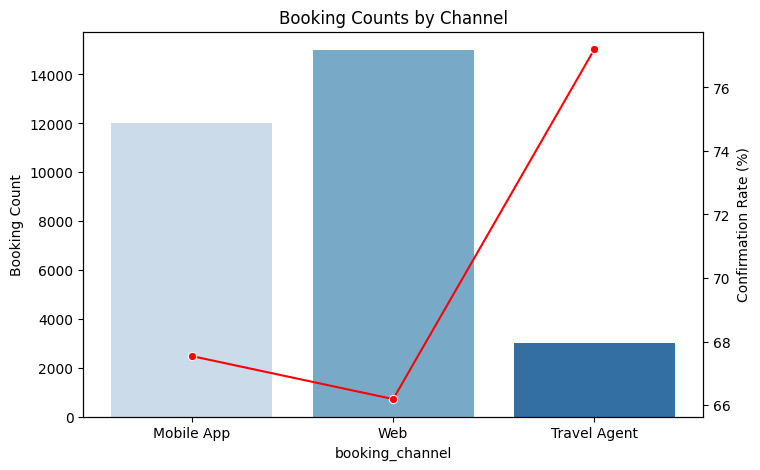

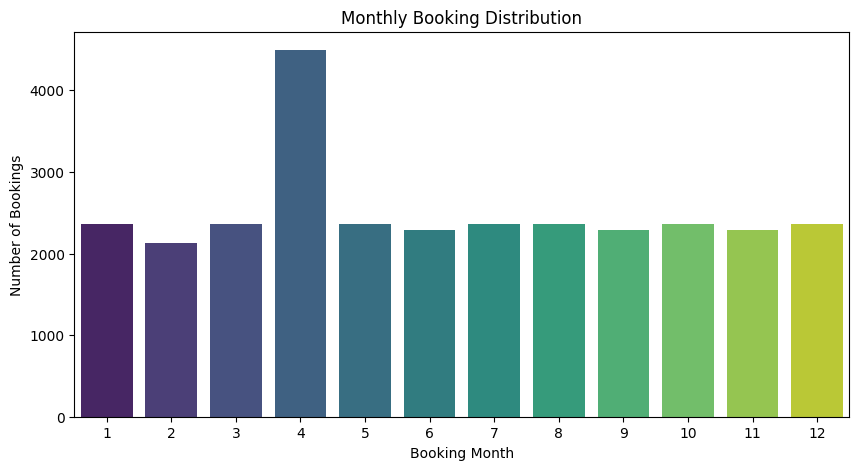

In [7]:
#Channel Performance
channel_counts = df['booking_channel'].value_counts()

fig, ax1 = plt.subplots(figsize=(8,5))
sns.countplot(data=df, x='booking_channel', ax=ax1, palette='Blues')
ax1.set_ylabel('Booking Count')
ax1.set_title('Booking Counts by Channel')

ax2 = ax1.twinx()
channel_conf_rates = df.groupby('booking_channel')['booking_status'].apply(lambda x: (x == 'Confirmed').mean()*100)
sns.lineplot(x=channel_conf_rates.index, y=channel_conf_rates.values, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Confirmation Rate (%)')
plt.show()

#Monthly Booking Counts
plt.figure(figsize=(10,5))
monthly_bookings = df.groupby('booking_month').size()
sns.barplot(x=monthly_bookings.index, y=monthly_bookings.values, palette='viridis')
plt.title('Monthly Booking Distribution')
plt.xlabel('Booking Month')
plt.ylabel('Number of Bookings')
plt.show()

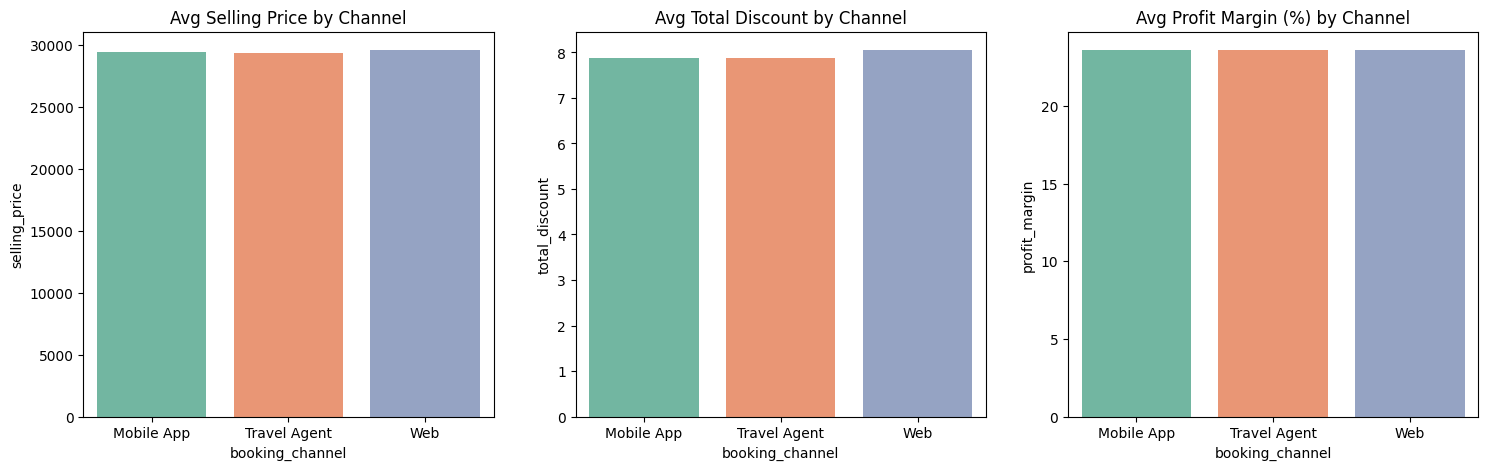

In [8]:
# 5 Channel Economics
channel_econ = df.groupby('booking_channel').agg({
    'selling_price': 'mean',
    'total_discount': 'mean',
    'profit_margin': 'mean'
}).reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.barplot(data=channel_econ, x='booking_channel', y='selling_price', ax=ax[0], palette='Set2')
ax[0].set_title('Avg Selling Price by Channel')
sns.barplot(data=channel_econ, x='booking_channel', y='total_discount', ax=ax[1], palette='Set2')
ax[1].set_title('Avg Total Discount by Channel')
sns.barplot(data=channel_econ, x='booking_channel', y='profit_margin', ax=ax[2], palette='Set2')
ax[2].set_title('Avg Profit Margin (%) by Channel')
plt.show()